In [1]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt, gc

train = pd.read_csv('hms-harmful-brain-activity-classification/train.csv')
print('Test shape', train.shape )
display( train.head(10) )

FileNotFoundError: [Errno 2] No such file or directory: 'hms-harmful-brain-activity-classification/train.csv'

In [2]:
NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

directory_path = 'EEG_Spectrograms/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

In [3]:
import pywt
print("The wavelet functions we can use:")
print(pywt.wavelist())

USE_WAVELET = "db8"

The wavelet functions we can use:
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5'

In [4]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

In [5]:
root = '/Volumes/MacOS/IITH/Sem-2/IVP_Project/hms-harmful-brain-activity-classification'

metadata = pd.read_csv(f'{root}/test.csv')
metadata

,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [7]:
def getWindowsfromEEG(eeg_id):
    # print(eeg_id)
    # eeg_id = 1628180742
    # eeg_df = metadata[metadata["eeg_id"] == eeg_id].reset_index(drop=True)
    eeg = pd.read_parquet(f'{root}/test_eegs/{eeg_id}.parquet')

    fs = 200
    eeg["time"] = eeg.index / fs
    eeg.set_index("time", inplace=True)
    eeg.index

    subSet = metadata[metadata['eeg_id']==eeg_id]
    # print(subSet)
    # offSets = [subSet['eeg_sub_id'].to_numpy(),subSet['eeg_label_offset_seconds'].to_numpy()]
    # offSets = np.array(offSets)
    


    toRet = []
    # for i in offSets[1]:
    toRet.append(eeg.loc[20:30])
    # toRet = np.array(toRet)
    return toRet,eeg


In [8]:
import librosa

def spectrogram_from_eeg(eeg_id, display=False):
    

    sliced_eegs,OG_eeg = getWindowsfromEEG(eeg_id)

    img = np.zeros((128,128,4),dtype='float32')
    
    if display: plt.figure(figsize=(10,7))

    retSpecs = []
    for idx,eeg in enumerate(sliced_eegs):
        # print(eeg.shape)
        signals = []
        for k in range(4):
            COLS = FEATS[k]
            # print(COLS)
            for kk in range(4):
            
                # COMPUTE PAIR DIFFERENCES
                x = eeg[COLS[kk]] - eeg[COLS[kk+1]]

                # FILL NANS
                m = np.nanmean(x)
                if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
                else: x[:] = 0

                # DENOISE
                if USE_WAVELET:
                    x = denoise(x, wavelet=USE_WAVELET)
                signals.append(x)

                # RAW SPECTROGRAM
                mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//128, 
                    n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

                # LOG TRANSFORM
                width = (mel_spec.shape[1]//32)*32
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

                # STANDARDIZE TO -1 TO 1
                mel_spec_db = (mel_spec_db+40)/40 
                img[:,:,k] += mel_spec_db
                    
            # AVERAGE THE 4 MONTAGE DIFFERENCES
            img[:,:,k] /= 4.0
        np.save(f'{eeg_id}_spec-{idx}.npy',img)
        # print(idx)
        # retSpecs.append(img)
    # print(retSpecs)
    # retSpecs = np.array(retSpecs)
    # return retSpecs


In [9]:
eeg_id = 3911565283
imgs = spectrogram_from_eeg(eeg_id)

In [10]:
def plotSpecs(spec):
    Labels  = ['LL','LP','RP','RR']
    fig = plt.figure(figsize=(10, 10)) 
    for i in range(1,5):

    
        fig.add_subplot(2,2,i )
        plt.title(f'{Labels[i-1]}', fontsize=12)
        plt.imshow(spec[:,:,i-1])
        plt.axis('off')

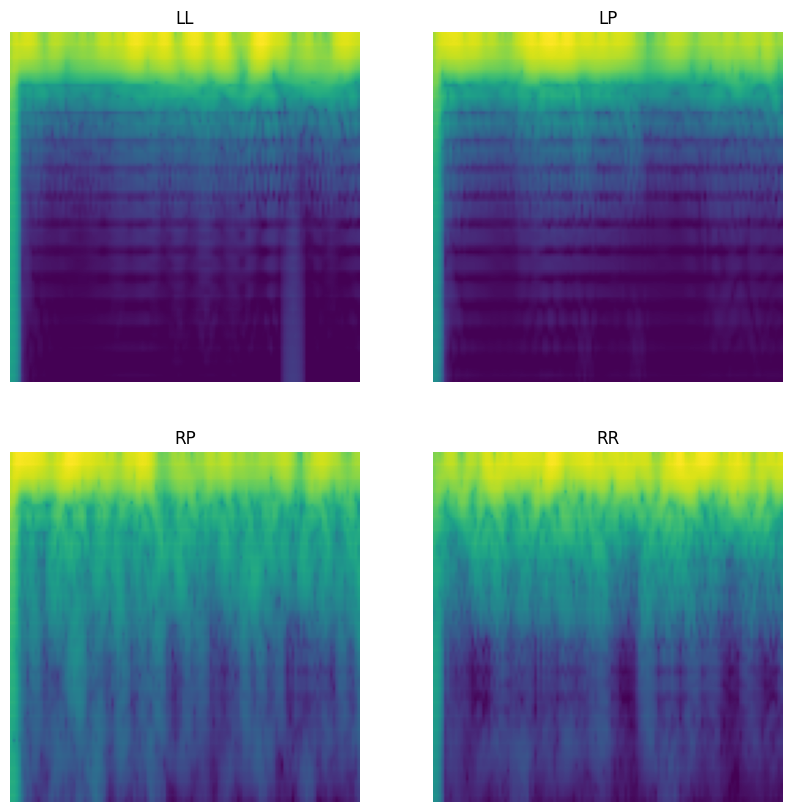

In [12]:
testEEg = np.load('3911565283_spec-0.npy')
plotSpecs(testEEg)